# Seismic data visualization

**Author: M.Ravasi**

In this notebook we will visualize the synthetic data modelled from the sharp Volve velocity model and the field data from the same acquisition line.

Whilst the two datasets are obviously not identical, this will give us a feeling of how similar the synthetic dataset is to the field one once sharp discontinuties are incorporated in the velocity model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.signal import convolve
from segyshot import SegyShot

## Real data

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


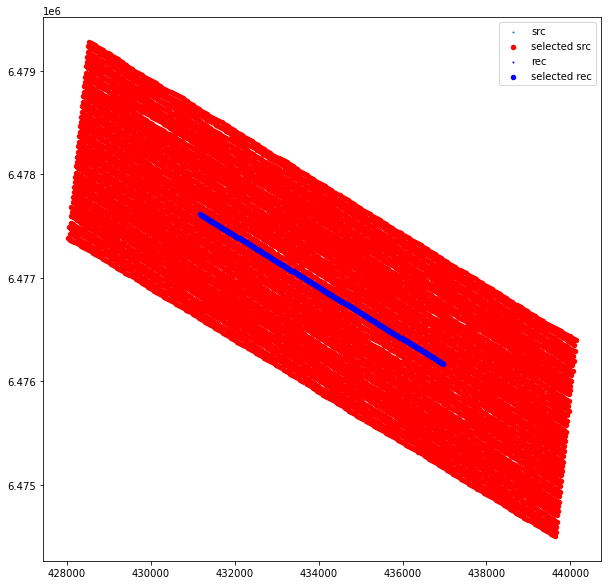

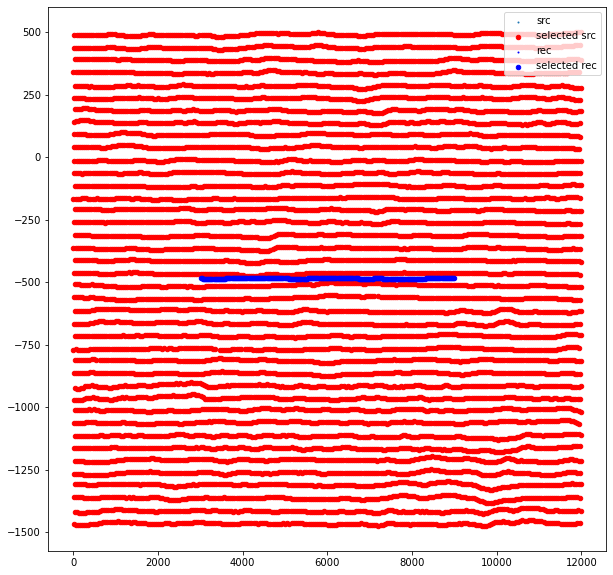

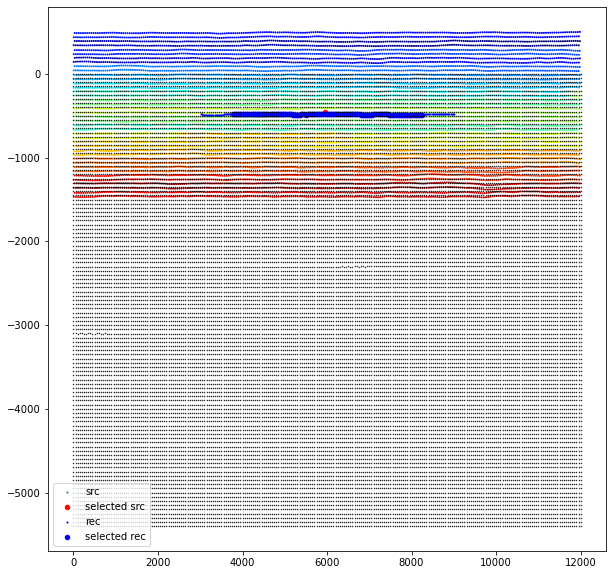

In [2]:
velfile = '../Data/Original/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
datafile = '../Data/Original/ST10010_1150780_40203.sgy'

# Intepret geometry
f = segyio.open(datafile, ignore_geometry=True)
ishotc = 5520
ishotin, ishotend = ishotc-120, ishotc+120
irecin, irecend = 30, 210

sg = SegyShot(datafile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()

_,_,_,_, (xvel_local, yvel_local) = \
    sg.rotategeometry(velfile=velfile, plotflag=0)
sg.showgeometry(local=True)

# Select shot
sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(ishotin, ishotend, plotflag=False)

sg.selectsrcs(ishotc, ishotc+1, plotflag=False)
sg.showgeometry(local=True)
plt.scatter(xvel_local, yvel_local, c='k', s=.2)

drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = sg.srcx_local[ishotc] - sg.recx_local[sg.selected_rec]
shot = sg.get_shotgather(ishotc)

## Synthetic data

Let's also load the synthetic data. Here we have 4 versions:

- `full_volvesynth`: OBC data with free-surface
- `nofs_full_volvesynth`: OBC data without free-surface
- `nosea_full_volvesynth`: data from seabed acquisition with seafloor flooding into the sea
- `volvesynth`: data from seabed acquisition with seafloor flooding into the sea and flat spectrum wavelet

In [3]:
fsynth = np.load('../Data/Modelling/input_full_volvesynth.npz') 
fsynth_nofs = np.load('../Data/Modelling/input_nofs_full_volvesynth.npz') 
fsynth_nosea = np.load('../Data/Modelling/input_nosea_full_volvesynth.npz') 
fsynth_noseaflat = np.load('../Data/Modelling/input_noseaflat_volvesynth.npz') 

psynth = fsynth['p'].transpose(0, 2, 1)
vzsynth = fsynth['vz'].transpose(0, 2, 1)
psynth_nofs = fsynth_nofs['p'].transpose(0, 2, 1)
psynth_nosea = fsynth_nosea['p'].transpose(0, 2, 1)
psynth_noseaflat = fsynth_noseaflat['pflat']
tsynth = fsynth['t']
rsynth = fsynth['r']
ssynth = fsynth['s']
t = fsynth['t']
wav = fsynth['wav']

ns, nr, nt = psynth.shape
dr = np.round(rsynth[0,1]-rsynth[0,0])
dt = t[1]-t[0]

# Select single source for plotting
offsynth = ssynth[0, 59] - rsynth[0]
offset = sg.srcx_local[ishotc] - sg.recx_local[sg.selected_rec]

## Visualization

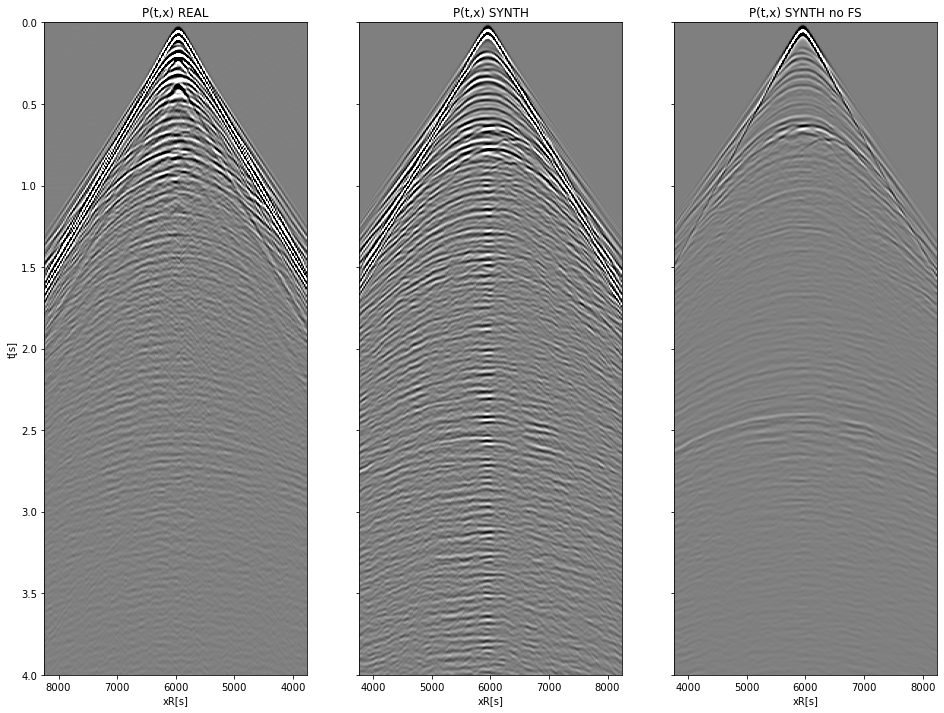

In [4]:
gain = np.sqrt(sg.t)
preal = -np.apply_along_axis(convolve, -1, shot['P'], wav, mode='full')
preal = preal[..., np.argmax(wav):][..., :len(sg.t)]
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 12))
axs[0].imshow(preal.T * gain[:, np.newaxis], cmap='gray', vmin=-2e6, vmax=2e6,
              extent = (sg.recx_local[sg.selected_rec][0], sg.recx_local[sg.selected_rec][-1], 
                        sg.t[-1], sg.t[0]))
axs[0].set_xlabel('xR[s]')
axs[0].set_ylabel('t[s]')
axs[0].set_title('P(t,x) REAL')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_xlabel('xR[s]')
axs[1].set_title('P(t,x) SYNTH')
axs[1].axis('tight')
axs[2].imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_xlabel('xR[s]')
axs[2].set_title('P(t,x) SYNTH no FS')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('../Figures/Volve_real_vs_synth.png')

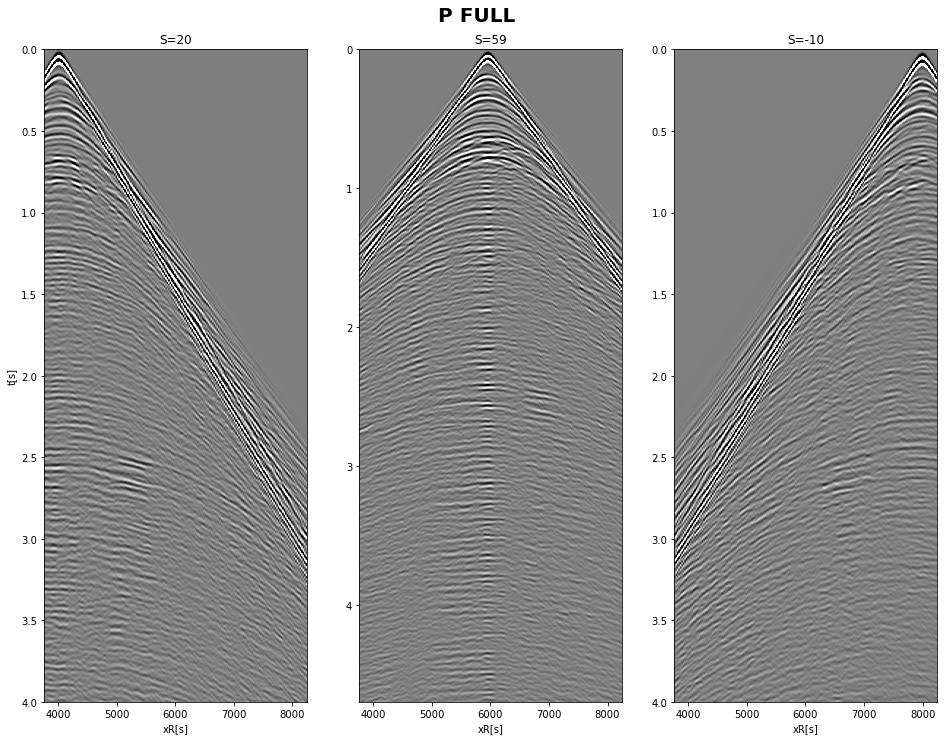

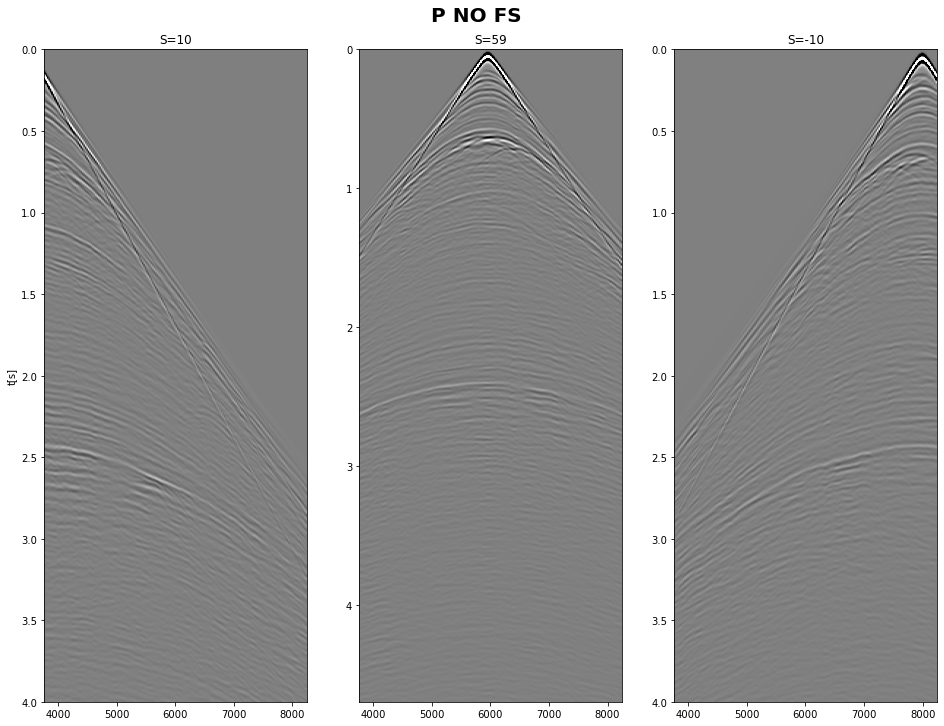

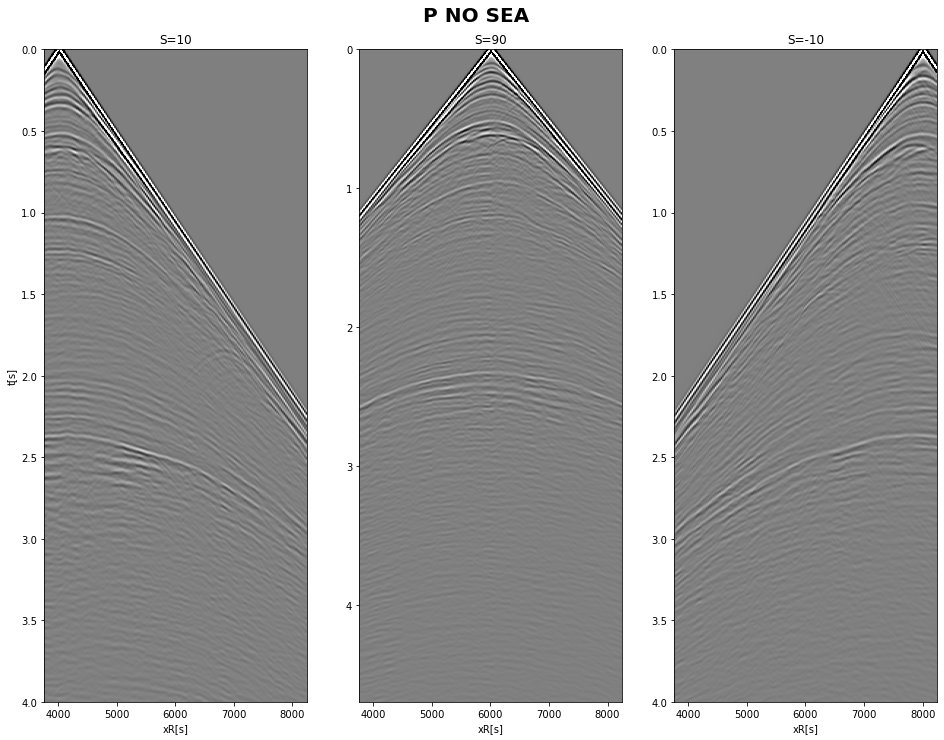

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P FULL', y=0.93, fontsize=20, fontweight='bold')
axs[0].imshow(psynth[20].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_xlabel('xR[s]')
axs[0].set_ylabel('t[s]')
axs[0].set_title('S=20')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_xlabel('xR[s]')
axs[1].set_title('S=59')
axs[1].axis('tight')
axs[2].imshow(psynth[-10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_xlabel('xR[s]')
axs[2].set_title('S=-10')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('../Figures/Volve_synthdata_p.png')

fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P NO FS', y=0.93, fontsize=20, fontweight='bold')
axs[0].imshow(psynth_nofs[10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_ylabel('t[s]')
axs[0].set_title('S=10')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_title('S=59')
axs[1].axis('tight')
axs[2].imshow(psynth_nofs[-10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title('S=-10')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('../Figures/Volve_synthdata_pnofs.png')

fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P NO SEA', y=0.93, fontsize=20, fontweight='bold')
axs[0].imshow(psynth_nosea[10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_ylabel('t[s]')
axs[0].set_xlabel('xR[s]')
axs[0].set_ylabel('t[s]')
axs[0].set_title('S=10')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth_nosea[90].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_xlabel('xR[s]')
axs[1].set_title('S=90')
axs[1].axis('tight')
axs[2].imshow(psynth_nosea[-10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_xlabel('xR[s]')
axs[2].set_title('S=-10')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('../Figures/Volve_synthdata_pnosea.png');